## Environment setup

In [1]:
import seaborn as sns
import pandas as pd
import numpy as np
import importlib
import uproot
import awkward as ak
import matplotlib.pyplot as plt
from matplotlib import colors

In [ ]:
!pip install awkward-pandas

## Data loading

### Load data from Tracks tree made with tpcReco

In [2]:
dataDirectory = "/scratch_hdd/akalinow/ELITPC/TPCReco/build_06_04_2023/resources/"
#dataFile = "TrackTree_MC_CoBo0_AsAdAll_2022-09-08T09:00:00.000_0000.root"
dataFile = "TrackTree_2023-05-05T09:00:00.000_0000.root"

treeName = ":trackTree"
inputObj = dataDirectory+dataFile+treeName

with uproot.open(inputObj) as file:
    array = file["track"].array(library="pd")
    df = ak.to_dataframe(array)
    #columns = df.columns
    #columnsClean = [aCol[0] for aCol in columns]
    #df.columns = columnsClean
    
df_RECO = df.rename(columns={'xVtx':'RECO_StartPosX',
    'yVtx':'RECO_StartPosY',
    'zVtx':'RECO_StartPosZ',
    'xAlphaEnd':'RECO_StopPosX_Part1',
    'yAlphaEnd':'RECO_StopPosY_Part1',
    'zAlphaEnd':'RECO_StopPosZ_Part1',
    'xCarbonEnd':'RECO_StopPosX_Part2',
    'yCarbonEnd':'RECO_StopPosY_Part2',
    'zCarbonEnd':'RECO_StopPosZ_Part2'})

df_RECO.describe()

,eventId,frameId,eventType,length,horizontalLostLength,verticalLostLength,alphaEnergy,carbonEnergy,alphaRange,carbonRange,...,RECO_StopPosY_Part1,RECO_StopPosZ_Part1,RECO_StopPosX_Part2,RECO_StopPosY_Part2,RECO_StopPosZ_Part2,total_mom_x,total_mom_y,total_mom_z,lineFitChi2,dEdxFitChi2
count,10000.00000,10000.00000,10000.000000,10000.000000,1.000000e+04,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,...,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,1.000000e+04,1.000000e+04
mean,4999.50000,4999.50000,2.978800,104.709445,inf,inf,4.707307,1.575420,92.999388,11.710056,...,-0.334891,-39.946402,0.051750,-0.071858,-39.021779,-5.643404,0.092813,-0.826116,inf,3.494767e+07
std,2886.89568,2886.89568,0.144058,12.536096,NaN,NaN,0.459181,0.435941,12.769663,2.445606,...,52.203210,30.765854,60.619764,16.556475,34.715248,25.338663,25.249774,19.474124,NaN,2.310985e+08
min,0.00000,0.00000,2.000000,7.751323,7.340629e+01,6.001327e+00,0.000000,0.000000,0.000000,0.000000,...,-717.140808,-120.350662,-778.884338,-741.120422,-116.448387,-214.898956,-212.026962,-216.781830,7.656194e-01,0.000000e+00
25%,2499.75000,2499.75000,3.000000,102.215084,1.042470e+02,8.566468e+00,4.603181,1.437677,89.648540,11.398327,...,-41.985601,-62.926801,-50.691574,-6.603094,-66.155054,-11.355811,-4.712102,-4.570574,1.331135e+04,1.405354e+06
50%,4999.50000,4999.50000,3.000000,104.853447,1.546322e+02,1.251668e+01,4.718268,1.609287,92.896549,12.067272,...,-1.044380,-59.564762,0.863354,0.537016,-63.655540,-5.174685,-0.032124,-0.025069,1.793983e+04,2.513286e+06
75%,7499.25000,7499.25000,3.000000,107.647991,2.935593e+02,2.397262e+01,4.831775,1.772900,96.154446,12.680461,...,41.491268,-17.552793,49.807323,6.569400,-12.469259,-0.240840,4.650397,4.648803,2.498782e+04,7.334908e+06
max,9999.00000,9999.00000,3.000000,313.304230,inf,inf,10.000404,4.993041,297.230011,23.430000,...,440.937531,103.739845,1100.557617,440.937531,65.525841,269.494324,214.798920,196.615311,inf,2.111050e+10


### Load a tree with generator level information. 

* select only interesting leafs
* rename the columns to match convention
* merge with reco tree

In [4]:
%%time 

fields = [
    #"SimEvent/reactionType",
    "SimEvent/tracks/tracks.startPos",
    "SimEvent/tracks/tracks.stopPos",
    #"SimEvent/tracks/tracks.prim.pID",
    #"SimEvent/tracks/tracks.prim.fourMomentum",
    #"Event/myChargeMap",
    #"Event/myChargeArray*",
    #"SimEvent/tracks/tracks.truncatedStartPosUVWT.*",
    #"SimEvent/tracks/tracks.truncatedStopPosUVWT.*",
]  

test_files = ['data/out_C_arr_5.root:TPCData']
batchSize = 10000
for array in uproot.iterate(test_files, step_size=batchSize, filter_name=fields, library="ak"):
    df = ak.to_dataframe(array)
    df_part1 = df.loc[(slice(None),0),:]
    df_part2 = df.loc[(slice(None),1),:]
    startXYZ = df_part1["tracks.startPos"]
    stopXYZ_part1 = df_part1["tracks.stopPos"]
    stopXYZ_part2 = df_part2["tracks.stopPos"]
    
    startXYZ = startXYZ.rename(columns={"fX":"GEN_StartPosX",
                                    "fY":"GEN_StartPosY",
                                    "fZ":"GEN_StartPosZ"}).reset_index(drop=True)
    
    stopXYZ_part1 = stopXYZ_part1.rename(columns={"fX":"GEN_StopPosX_Part1",
                                    "fY":"GEN_StopPosY_Part1",
                                    "fZ":"GEN_StopPosZ_Part1"}).reset_index(drop=True)
    
    stopXYZ_part2 = stopXYZ_part2.rename(columns={"fX":"GEN_StopPosX_Part2",
                                    "fY":"GEN_StopPosY_Part2",
                                    "fZ":"GEN_StopPosZ_Part2"}).reset_index(drop=True)
    
    df_GEN = pd.concat([startXYZ,stopXYZ_part1,stopXYZ_part2], axis=1)  

    break 
    
    
df = pd.concat([df_GEN, df_RECO], axis=1)

CPU times: user 86 ms, sys: 369 µs, total: 86.4 ms
Wall time: 85.8 ms


<Axes: >

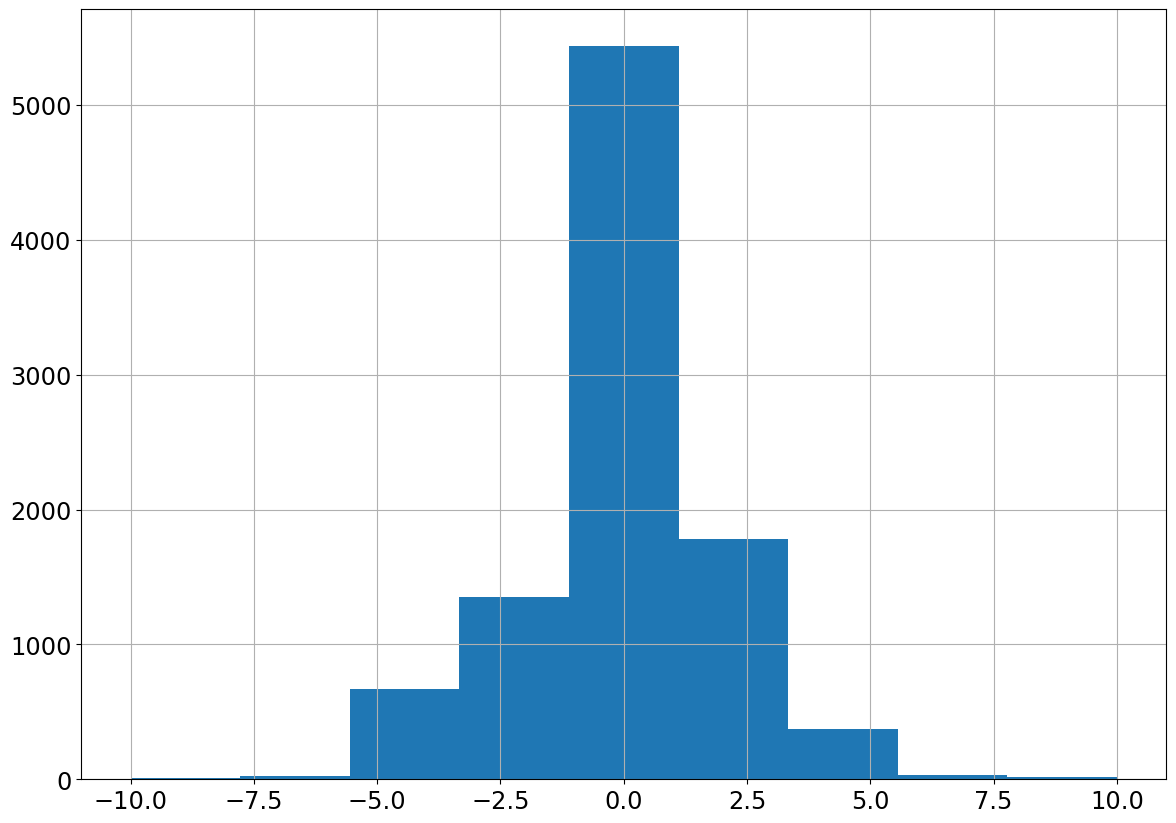

In [10]:
df[["GEN_StartPosX","GEN_StartPosY", "RECO_StartPosX", "RECO_StartPosY"]]


(df["GEN_StartPosX"] - df["RECO_StartPosX"]).hist(bins=np.linspace(-10,10,10))

### Resolution plots

2023-05-05 13:01:33.755674: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/scratch_hdd/akalinow/ELITPC/PythonAnalysis/utility_functions.py:66: RuntimeWarning: invalid value encountered in divide
  track1 /=norm
/scratch_hdd/akalinow/ELITPC/PythonAnalysis/utility_functions.py:70: RuntimeWarning: invalid value encountered in divide
  track2 /=norm


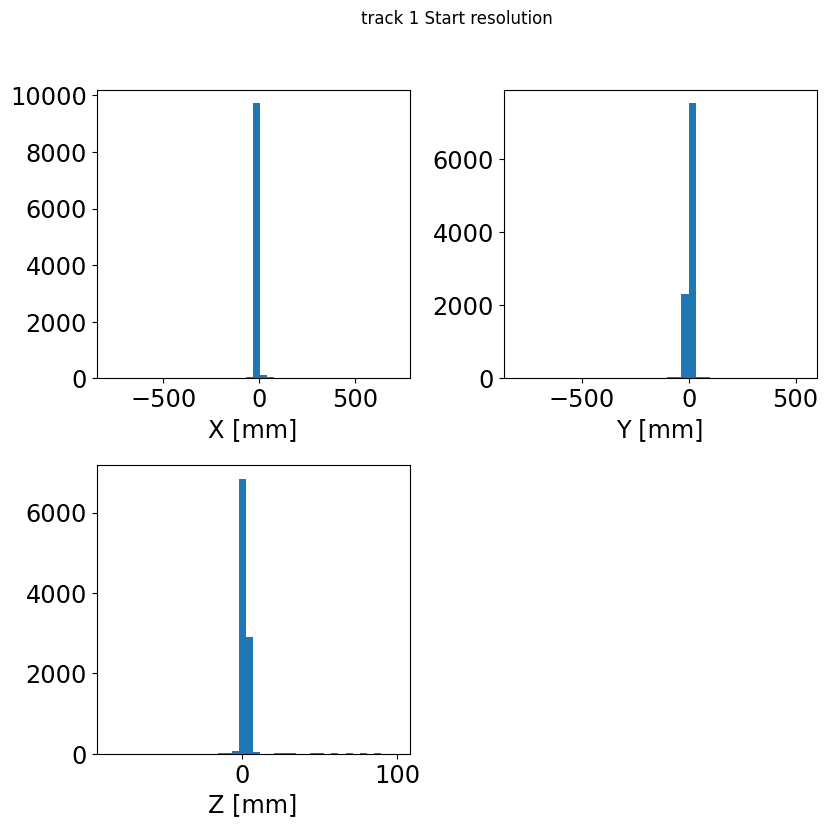

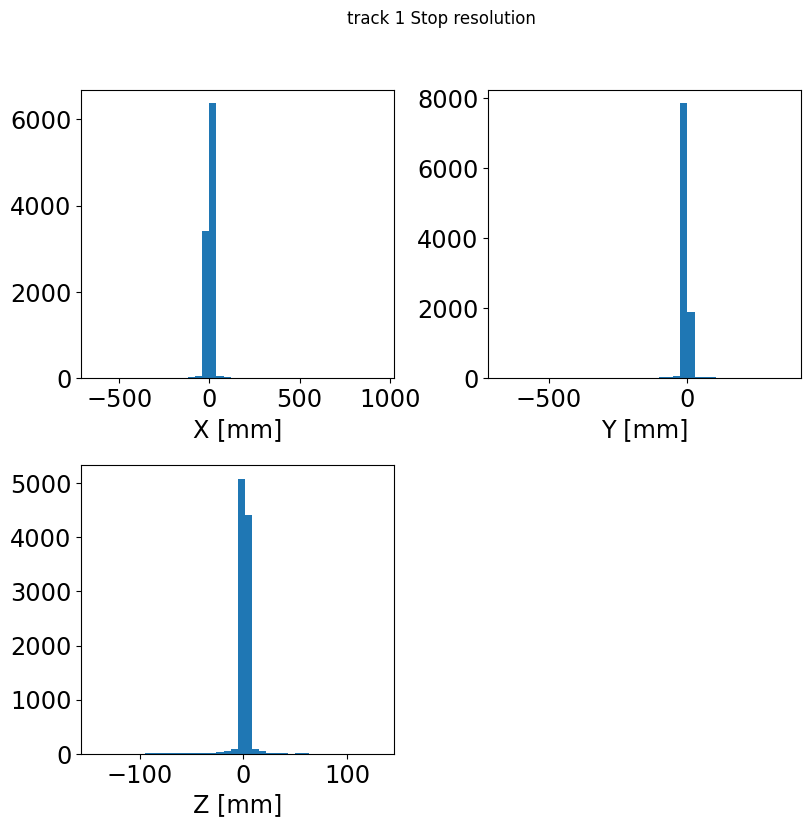

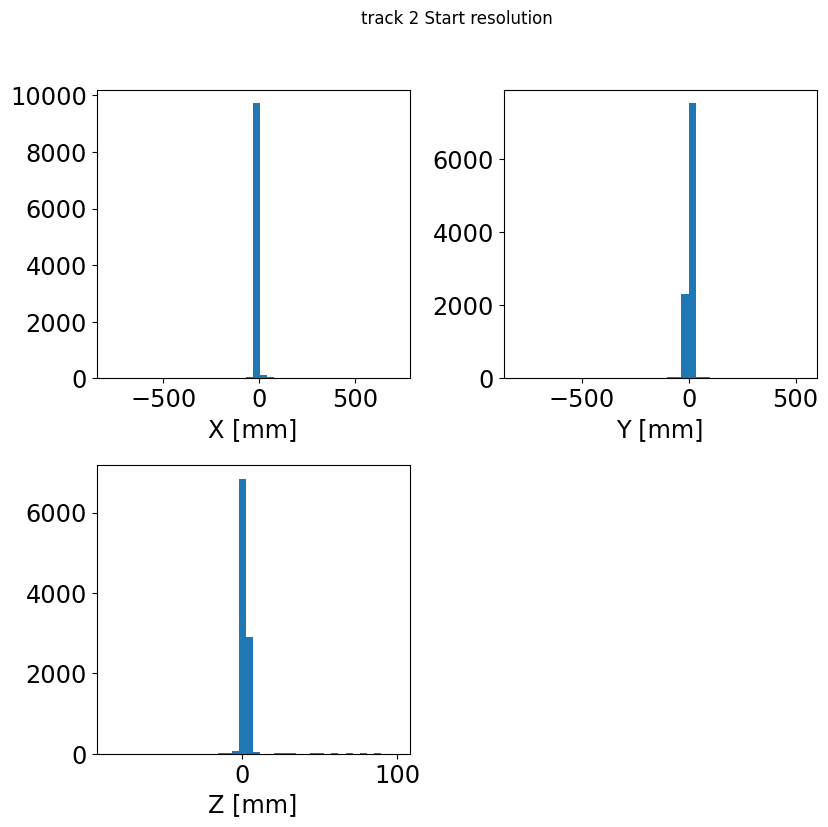

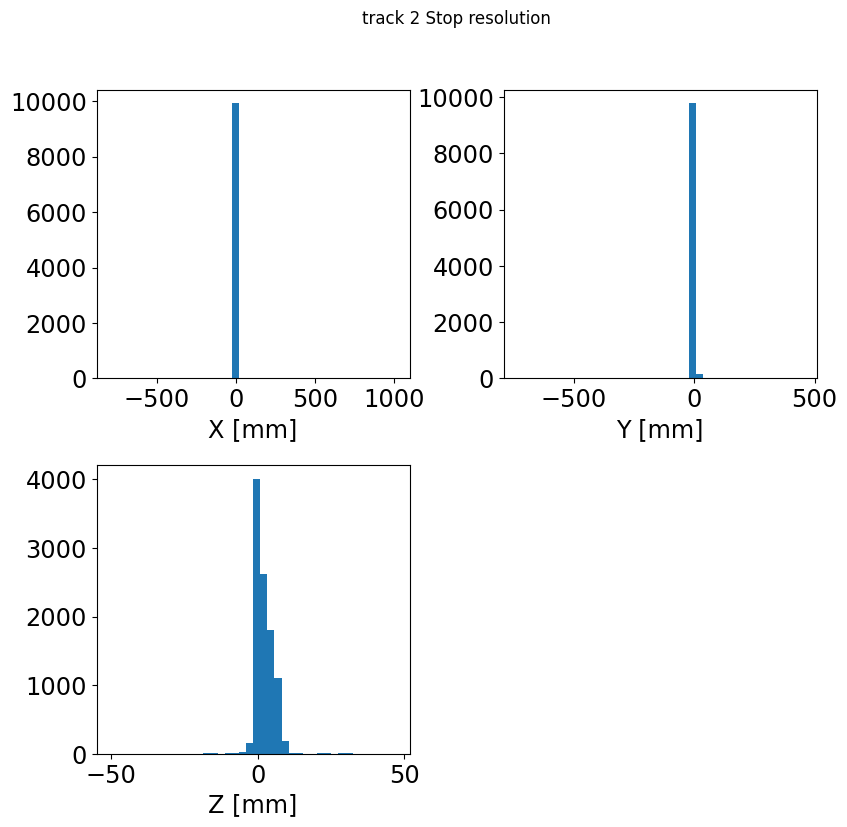

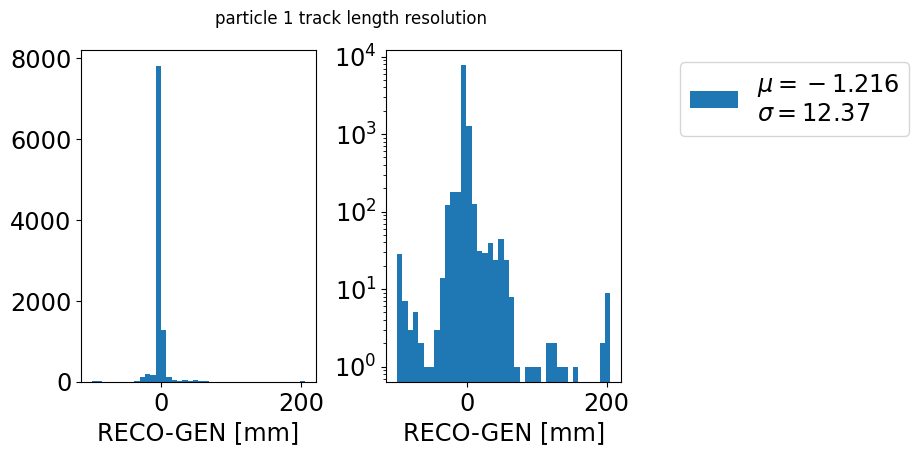

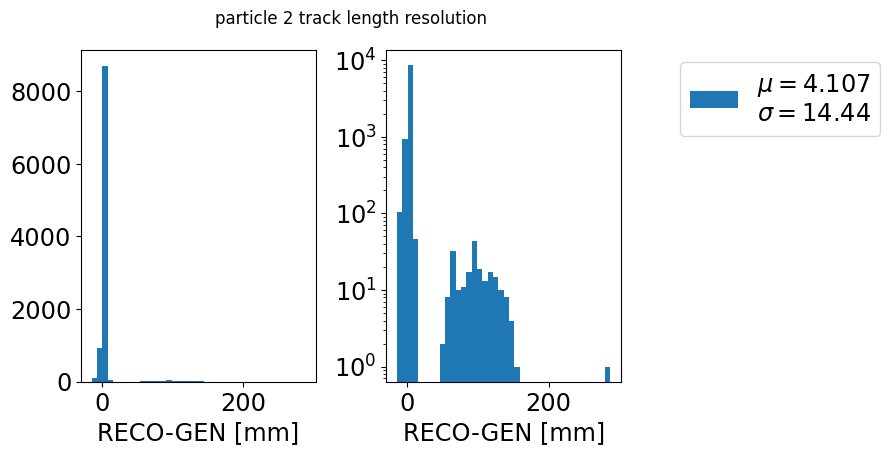

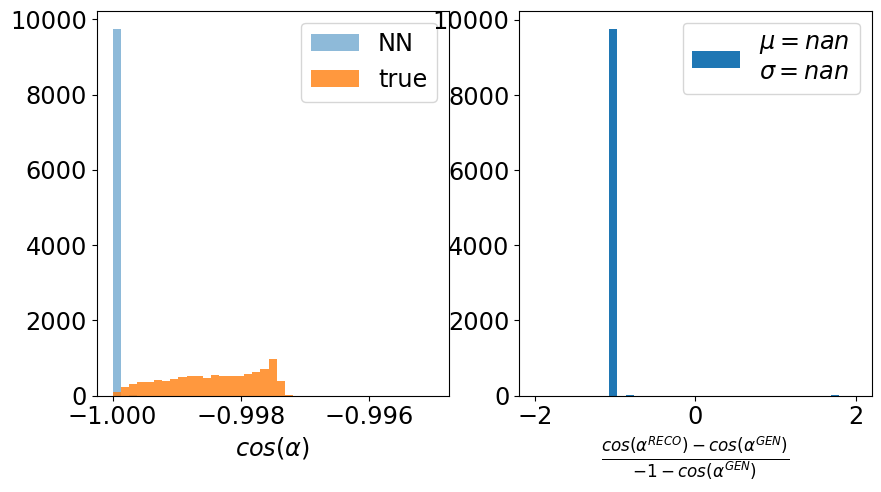

In [6]:
import plotting_functions as plf
importlib.reload(plf)

#plf.controlPlots(df)
plf.plotEndPointRes(df=df, edge="Start", partIdx=1)
plf.plotEndPointRes(df=df, edge="Stop", partIdx=1)

plf.plotEndPointRes(df=df, edge="Start", partIdx=2)
plf.plotEndPointRes(df=df, edge="Stop", partIdx=2)

plf.plotLengthPull(df, partIdx=1)
plf.plotLengthPull(df, partIdx=2)
plf.plotOpeningAngleCos(df)

### Resolution plots for filtered dataset

       GEN_StartPosX  GEN_StartPosY  GEN_StartPosZ  GEN_StopPosX_Part1  \
count    4455.000000   4.455000e+03    4455.000000         4455.000000   
mean        0.401693  -1.475499e-06     -58.655523           -2.607059   
std        58.132128   2.135312e-04      13.079452           81.456060   
min       -99.944790  -3.673189e-04     -66.343274         -175.992942   
25%       -51.075356  -1.877862e-04     -63.392091          -61.871414   
50%         0.213733  -7.850854e-07     -61.080466           -2.965547   
75%        51.123254   1.876103e-04     -58.867890           56.582928   
max        99.999570   3.671177e-04      28.928123          176.696236   

       GEN_StopPosY_Part1  GEN_StopPosZ_Part1  GEN_StopPosX_Part2  \
count         4455.000000         4455.000000         4455.000000   
mean            -0.727448          -17.655255           -0.144667   
std             51.142085           29.753500           58.558060   
min            -95.828873          -66.387600         -11

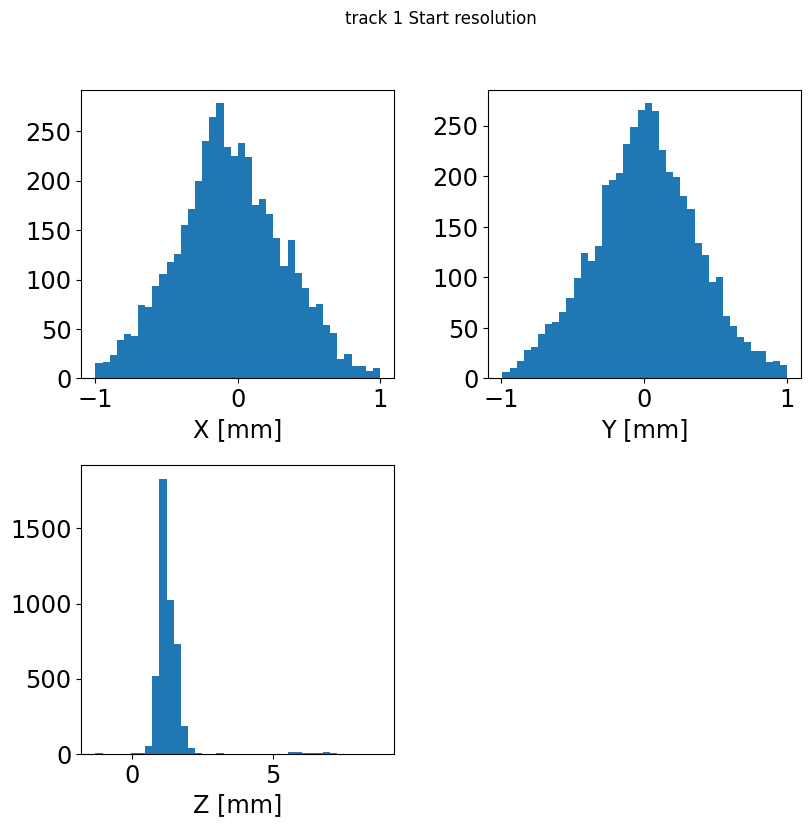

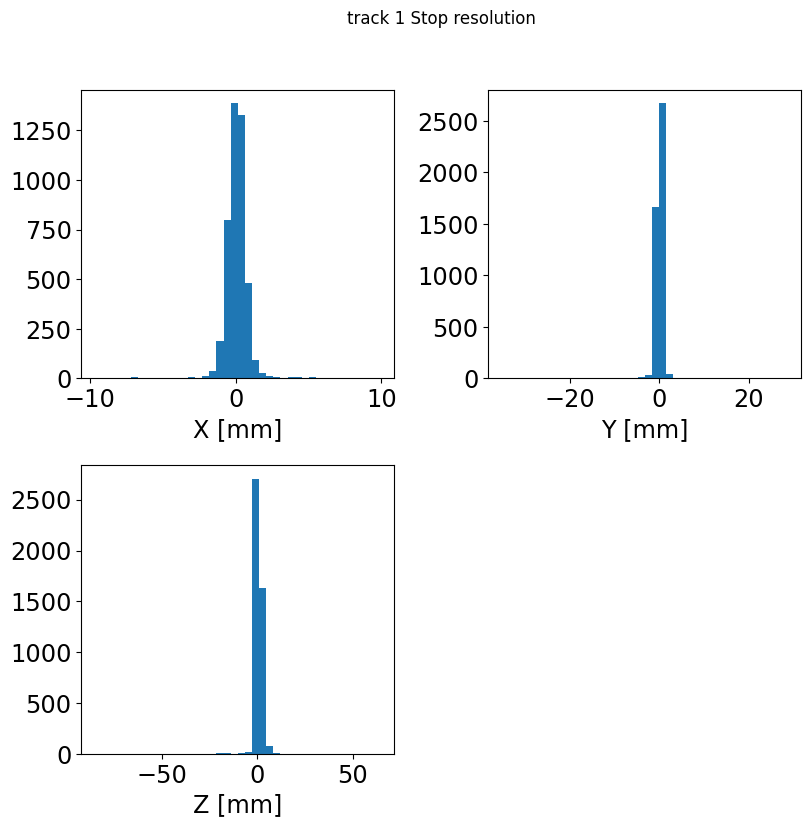

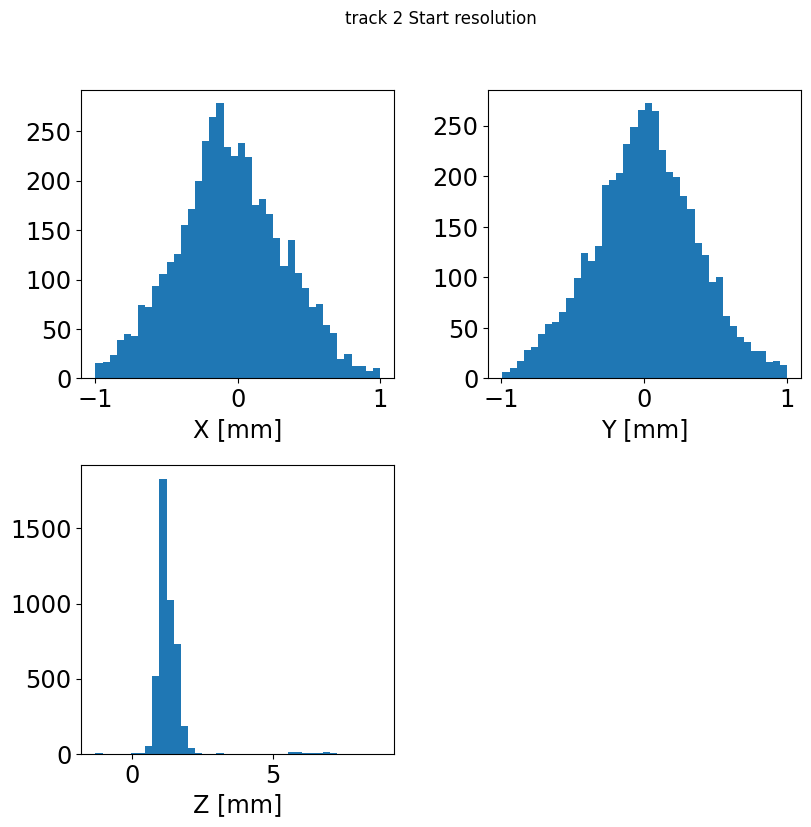

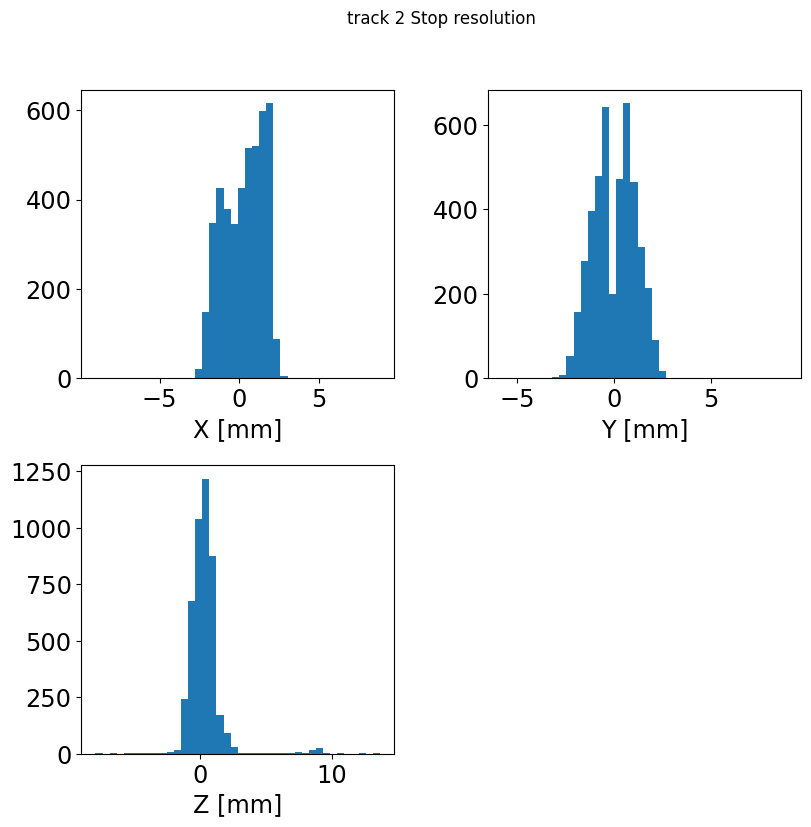

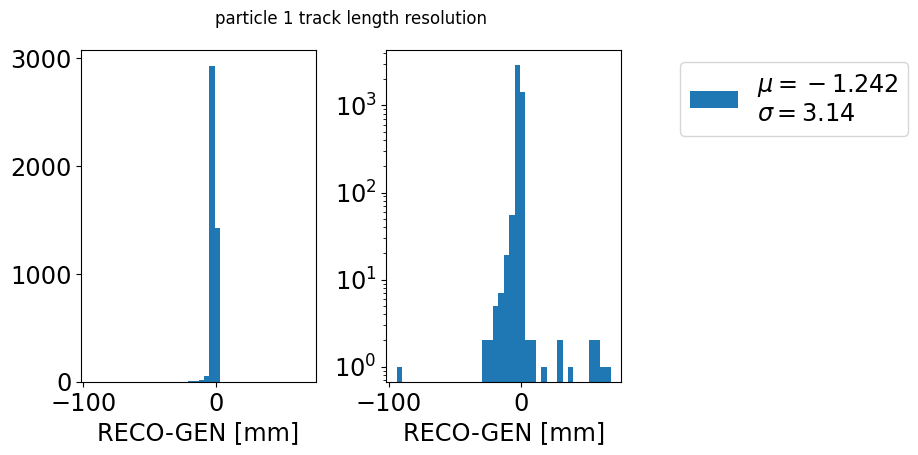

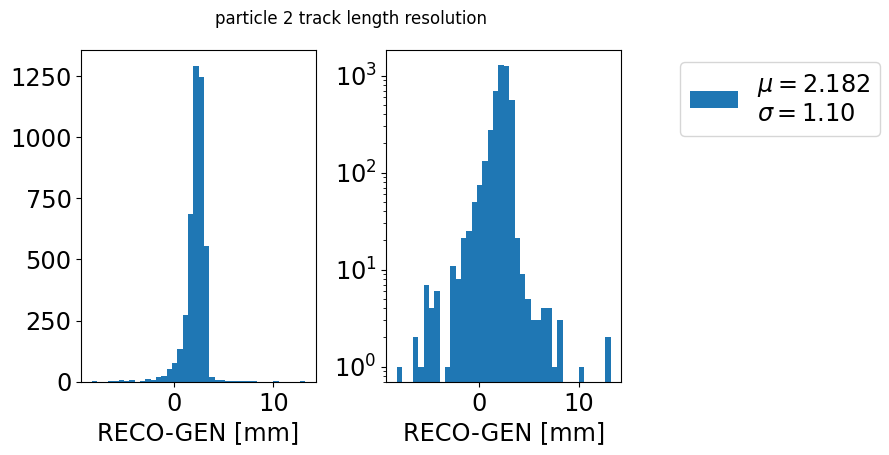

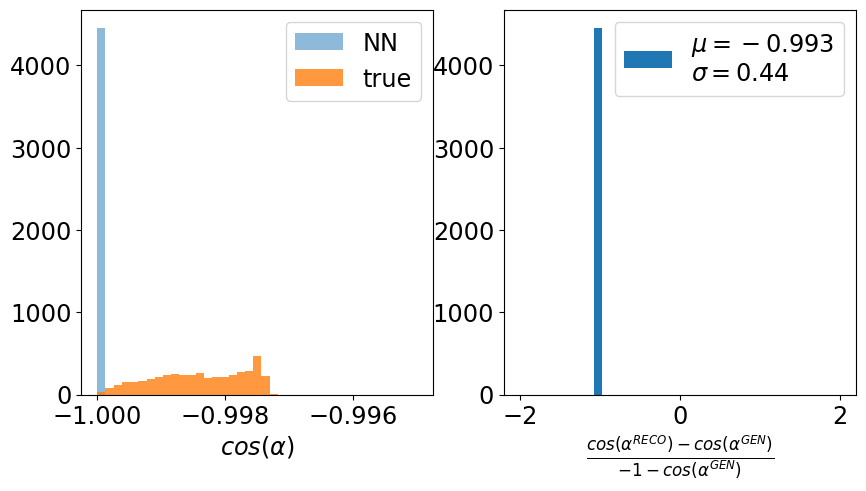

In [21]:
mask = np.abs(df["GEN_StartPosX"] - df["RECO_StartPosX"])<1
df_filtered = df[mask]

mask = np.abs(df_filtered["GEN_StartPosY"] - df_filtered["RECO_StartPosY"])<1
df_filtered = df_filtered[mask]

mask = np.abs(df_filtered["GEN_StopPosX_Part1"] - df_filtered["RECO_StopPosX_Part1"])<10
df_filtered = df_filtered[mask]

print(df_filtered.describe())

plf.plotEndPointRes(df=df_filtered, edge="Start", partIdx=1)
plf.plotEndPointRes(df=df_filtered, edge="Stop", partIdx=1)

plf.plotEndPointRes(df=df_filtered, edge="Start", partIdx=2)
plf.plotEndPointRes(df=df_filtered, edge="Stop", partIdx=2)

plf.plotLengthPull(df_filtered, partIdx=1)
plf.plotLengthPull(df_filtered, partIdx=2)
plf.plotOpeningAngleCos(df_filtered)

## 2D plots 

In [ ]:
params = {'legend.fontsize': 'xx-large',
          'figure.figsize': (14, 10),
         'axes.labelsize': 'xx-large',
         'axes.titlesize':'xx-large',
         'xtick.labelsize':'xx-large',
         'ytick.labelsize':'xx-large',
         #'xticks':'major_ticks_top'
         }

plt.rcParams.update(params)


fig, axes = plt.subplots(2, 2, figsize = (10, 10))

'''
trackTree->Draw("(alphaRangeReco-alphaRangeGen)/alphaRangeGen:alphaRangeGen>>hRangeResVsRangeGen(21,0, 70,  41,-0.5,0.5)","","goff");
trackTree->Draw("(alphaRangeReco-alphaRangeGen)/alphaRangeGen:cosThetaGen>>hRangeResVsCosTheta(21,-1, 1,  41,-0.5,0.5)","","goff");
trackTree->Draw("abs(cosThetaReco)-abs(cosThetaGen):cosThetaGen>>hCosThetaResVsCosTheta(21,-1, 1,  41,-0.5,0.5)","","goff");
trackTree->Draw("asin(sin(phiReco-phiGen)):cosThetaGen>>hPhiResVsCosTheta(21,-1, 1,  41,-0.5,0.5)","","goff");
trackTree->Draw("(chargeReco-chargeGen)/chargeGen:cosThetaGen>>hChargeResVsCosTheta(21,-1, 1,  41,-0.5,0.5)","","goff");
'''

x = df["alphaRangeGen"]
y = df.eval("(alphaRangeReco -alphaRangeGen)/alphaRangeGen")
xBins = np.linspace(0,60,20)
yBins = np.linspace(-0.5,0.5,20)
axes[0,0].hist2d(x, y, bins=(xBins, yBins), cmin=10, label="length")
axes[0,0].set_xlabel(r'$\alpha~range [mm]$')
axes[0,0].set_ylabel(r'$\frac{RECO-GEN}{GEN}$')

x = df["cosThetaGen"]
xBins = np.linspace(-1,1,20)
yBins = np.linspace(-0.5,0.5,20)
axes[0,1].hist2d(x, y, bins=(xBins, yBins), cmin=10, label="length")
axes[0,1].set_xlabel(r'$\cos(\theta)$')
axes[0,1].set_ylabel(r'$\frac{RECO-GEN}{GEN}$')

x = df["phiGen"]
xBins = np.linspace(-np.pi,np.pi,20)
yBins = np.linspace(-0.5,0.5,20)
axes[1,0].hist2d(x, y, bins=(xBins, yBins), cmin=10, label="length")
axes[1,0].set_xlabel(r'$\varphi$')
axes[1,0].set_ylabel(r'$\frac{RECO-GEN}{GEN}$')

x = df["dEdxFitChi2"]
xBins = np.linspace(x.min(),x.median(),20)
yBins = np.linspace(-0.5,0.5,20)
axes[1,1].hist2d(x, y, bins=(xBins, yBins), cmin=10, label="length")
axes[1,1].set_xlabel(r'$\frac{dE}{dx}$ fit loss func.')
axes[1,0].set_ylabel(r'$\frac{RECO-GEN}{GEN}$')

plt.subplots_adjust(bottom=0.15, left=0.05, right=0.95, wspace=0.35, hspace=0.3)
#plt.savefig("fig_png/2D_plots.png", bbox_inches="tight")

In [ ]:
yBins

In [ ]:
df["dEdxFitChi2"].median()